# SISO for Ground Motion Events

In [1]:
import mdof
from mdof import modal, transform
import sdof
import numpy as np
from numpy import linspace, sqrt, pi
from mdof.utilities.config import Config
from mdof.utilities.printing import *
from mdof.numerics import decimate

## Unknown system with one input and one output
parameter | value
----------|-------
$\omega_n$  | natural period
$\zeta$  | damping ratio

![sdof2](./figures/sdof2.png)

## Configure

### Inputs

In [2]:
inputs  = np.loadtxt("uploads/elcentro.txt")
dt = 0.02

# ta = np.arange(0, inputs.size*dt, dt)
t = linspace(0, (inputs.size-1)*dt, len(inputs))

### Outputs

In [3]:
outputs = None

In [4]:
# Example SDOF system
mass = 1       # mass
k = 30         # stiffness
zeta = 0.01    # damping ratio

Generate output if one was not given:

In [5]:
if outputs is None:
    omega_n = sqrt(k/mass)  # natural frequency (rad/s)
    Tn = 2*pi/omega_n  # natural periods (s)
    c = 2*zeta*mass*omega_n    # damping coefficient
    print(f"natural period: {Tn:<3.5}s")
    print(f"damping ratio:  {zeta}")
    displ, veloc, outputs = sdof.integrate(mass,c,k,inputs,dt)

natural period: 1.1471s
damping ratio:  0.01


#### Method

In [6]:
conf = Config()
conf.decimation = 1 # transfer function decimation

## Analysis with System Identification

#### Transfer Function Methods

In [7]:
# Set parameters
conf.damping = zeta
conf.period_band = (0.1,3) # Period band (s)
conf.pseudo = True # use pseudo accelerations (Sa)

# A place to store models and their predictions
transfer_models = {}

# Generate a transfer function representation of the system
transfer_models["Fourier Transform"] = transform.fourier_transfer(inputs, outputs, dt, **conf)
transfer_models["Response Spectrum"] = transform.response_transfer(inputs, outputs, dt, **conf)

# Determing the fundamental frequency
fourier_periods, fourier_amplitudes = modal.spectrum_modes(*transfer_models["Fourier Transform"])
response_periods, response_amplitudes = modal.spectrum_modes(*transfer_models["Response Spectrum"], height=10)

#### State Space Methods

In [8]:
# Generate a state space realization of the system
conf.decimation = 1
conf.order = 2
conf.horizon = 300
realization = mdof.system(method="srim", inputs=inputs, outputs=outputs, **conf)
# Obtain natural period and damping ratio from the state space model
ss_modes = modal.system_modes(realization, dt, **conf)
print_modes(ss_modes, Tn=Tn, zeta=zeta)


100%|█████████▉| 3695/3696 [00:00<00:00, 68985.57it/s]

Spectral quantities:
       T(s)        ζ        EMACO        MPC     EMACO*MPC          T % error    ζ % error
      1.148      0.00998    1.0        1.0        1.0          0.0999       -0.1995  
Mean Period(s): 1.1482934446028523
Standard Dev(s): 0.0


#### Visualize Transfer Functions vs. State Space Methodds

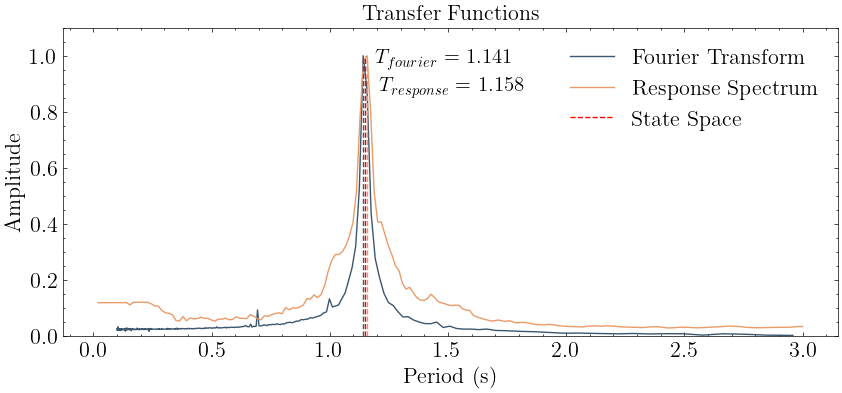

In [9]:
plot_transfer(transfer_models, title="Transfer Functions")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.gcf().axes[0].vlines([fourier_periods[0], response_periods[0]],ymin=0,ymax=1,linestyles='--',colors=color_cycle[:2])
plt.gcf().axes[0].vlines(1/ss_modes[next(iter(ss_modes.keys()))]["freq"],ymin=0,ymax=1,linestyles='--',colors='r',label="State Space")
plt.gcf().axes[0].legend()
plt.gcf().axes[0].text(fourier_periods[0]+0.05,0.975,r"$T_{fourier}$ = "+str(np.round(fourier_periods[0],3)),fontsize=15)
plt.gcf().axes[0].text(response_periods[0]+0.05,0.875,r"$T_{response}$ = "+str(np.round(response_periods[0],3)),fontsize=15)
plt.gcf().axes[0].set_ylim((0,1.1));

# fig, ax = plt.subplots(figsize=(5,3))
# ax.plot(*transfer_models["Fourier Transform"] )
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
# ax.set_xlabel("Period (s)")
# ax.set_ylabel("Amplitude")
# plt.gcf().savefig("output/transfer.svg");

In [10]:
assert np.isclose(1/Tn, ss_modes[next(iter(ss_modes.keys()))]["freq"], atol=1e-2), (1/Tn, 1/ss_modes[next(iter(ss_modes.keys()))]["freq"])
assert np.isclose(Tn, fourier_periods[0], atol=1e-2)

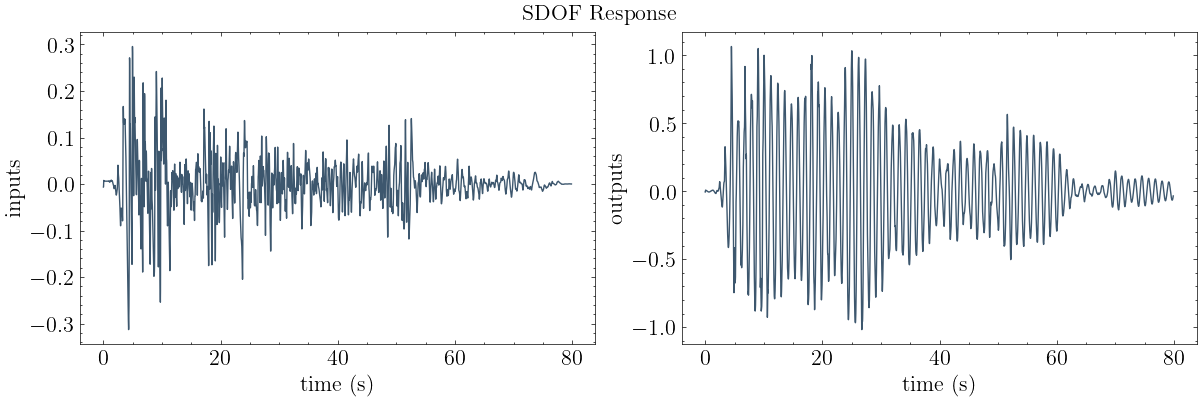

In [11]:
plot_io(inputs=inputs, outputs=outputs, t=t, title="SDOF Response")

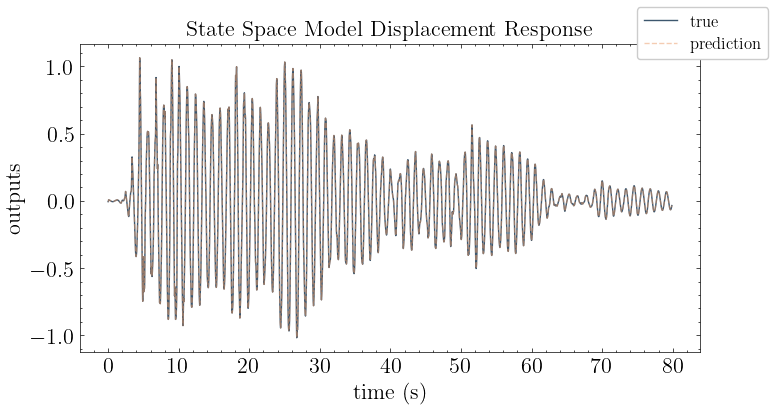

In [12]:
# Reproduce the response with the state space model
from control import ss, forced_response
out_mdof = forced_response(ss(*realization,dt*conf.decimation), U=decimate(inputs,conf.decimation), squeeze=False, return_x=False).outputs
plot_pred(ytrue=decimate(outputs,conf.decimation), models=out_mdof, t=decimate(t,conf.decimation), title="State Space Model Displacement Response")

# color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
# fig, ax = plt.subplots(figsize=(5,4))
# ax.step(decimate(t,conf.decimation*16),decimate(outputs,conf.decimation*16),label="true")
# ax.plot(decimate(t,conf.decimation),decimate(out_mdof[0,:],1),"--",label=f"prediction")
# ax.set_xlabel("Time (s)")# , fontsize=13)
# ax.set_ylabel("Output")# , fontsize=13)
# ax.set_xlim((25,45))
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False);